Project:
If we decrease the school's funding, by how much does their ability to understand Math, English, Science, and History decrease?

# Grabbing the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.datasets

from pandas import Series, DataFrame

plt.style.use('bmh')

%matplotlib inline

Read in the states.csv and clean it up

The states csv file has some data that we can not use. Specifically, the test scores we have only goes from 2005 through 2015, while the states funding file goes from 1992 through 2016. As such we need to remove the rows where we do not have test score data. This is done because with out those test scores, the funding information doesnt really help us.

With this done, we can move on to clearing out the columns that we do not need. We only really need the state, year, enrollment, and total expenditure (total_expenditure as that was what was spent in total for the students). The state and year columns will be used to match rows to the test scores file. The enrollment and total expenditure will be used to determine what was spent on each student, while the total expediture will be used on its own to know the total amount spent in the state for that year.

In [2]:
# states csv
statesdf = pd.read_csv("states.csv")

statesdf2 = statesdf[(statesdf['YEAR'] > 2004) & (statesdf['YEAR'] < 2016)]
stateInfo = statesdf2[['STATE', 'YEAR', 'ENROLL', 'TOTAL_EXPENDITURE']]
stateInfo

,STATE,YEAR,ENROLL,TOTAL_EXPENDITURE
663,Alabama,2005,729342.0,5904664
664,Alaska,2005,132568.0,1751718
665,Arizona,2005,919875.0,7136794
666,Arkansas,2005,461667.0,3999608
667,California,2005,6307022.0,66196072
...,...,...,...,...
1219,Virginia,2015,1279867.0,16113212
1220,Washington,2015,1072359.0,13630138
1221,West Virginia,2015,279565.0,3466981
1222,Wisconsin,2015,861813.0,11553677


Read in the school_scores.csv and clean it up

For this file we are able to keep all of the rows, as the data is from the years that we need. Since the states.csv grabbed all of the years that we have data for in the school_scores.csv, do not need to remove any rows that we have in our csv file.

That being said, we will need to remove some columns. To start with we will need to keep the columns for year, and state name as they contain the information that will be used to undrstand which scores go to which information about the funding from the other table. At this point we need to understand what it is that we are trying to figure out. We want to figure out by how much does a students ability to understand a subject decrease when the school loses access to funding. So that means that we want to track the students GPA for that subject as the SAT scores do not have enough information that we can use. The GPA scores on the other hand, track the average GPA for their specific topic ONLY. This means we can track each subject across the years indivdualy which is what we want.

In [3]:
# school scores csv
scoresdf = pd.read_csv("school_scores.csv")

scoresInfo = scoresdf[['Year', 'State.Name', 'Academic Subjects.English.Average GPA', 'Academic Subjects.Mathematics.Average GPA', 'Academic Subjects.Natural Sciences.Average GPA', 'Academic Subjects.Social Sciences/History.Average GPA']]
scoresInfo

,Year,State.Name,Academic Subjects.English.Average GPA,Academic Subjects.Mathematics.Average GPA,Academic Subjects.Natural Sciences.Average GPA,Academic Subjects.Social Sciences/History.Average GPA
0,2005,Alabama,3.53,3.41,3.52,3.59
1,2005,Alaska,3.35,3.06,3.25,3.39
2,2005,Arizona,3.45,3.25,3.43,3.55
3,2005,Arkansas,3.61,3.46,3.55,3.67
4,2005,California,3.32,3.05,3.20,3.38
...,...,...,...,...,...,...
572,2015,Virginia,3.47,3.17,3.38,3.46
573,2015,Washington,3.50,3.22,3.37,3.48
574,2015,West Virginia,3.71,3.47,3.58,3.70
575,2015,Wisconsin,3.77,3.64,3.70,3.76


# Cleaning the Data

At this point we have all the information that we are going to use, and now we can do some preliminary tests of the data. We should do some basic tests to make sure that there are no null data points in either dataframe, and we should determine if we have the same number of states for each year in each dataframe. If there are some states without information then we will need to figure out what we should do with those states.

In [4]:
print(f"There are {stateInfo.isnull().sum().sum()} null values in the stateInfo dataframe")

print(f'There are {scoresInfo.isnull().sum().sum()} null values in the scoresInfo dataframe')

There are 0 null values in the stateInfo dataframe
There are 0 null values in the scoresInfo dataframe


We can see that there are no null values in either dataframe. That is a good thing, as it means that we will have data for everything that exists in the data frames. But we need to check if we have the same amount of data for each state.

In [5]:
print("Year and number of entries per year for stateInfo dataframe.")
print(stateInfo['YEAR'].value_counts())

print("\n\n")

print('Year and number of entries per year for scoresInfo dataframe.')
print(scoresInfo['Year'].value_counts())

Year and number of entries per year for stateInfo dataframe.
2005    51
2006    51
2007    51
2008    51
2009    51
2010    51
2011    51
2012    51
2013    51
2014    51
2015    51
Name: YEAR, dtype: int64



Year and number of entries per year for scoresInfo dataframe.
2007    53
2008    53
2011    53
2012    53
2013    53
2014    53
2015    53
2005    52
2006    52
2009    51
2010    51
Name: Year, dtype: int64


As you can see above, the scores dataframe has some extra entries per year for some of the years which is not helpful. Below is us trying to understand what the scoresInfo also has. To do this we will count the number of times that each state appears in each list. (will need to remove Vigin Islands, Puerto Rico from scores)

In [6]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
          'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
          'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
          'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 
          'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
          'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
for i in range(len(states)):
    states[i] = states[i].lower()

    
stateStates = [0 for i in range(51)]
non_states = []
for row in stateInfo.itertuples():
    state = row[1].lower()
    if state in states:
        index = states.index(state)
        stateStates[index] += 1
    else:
        non_states.append(state)
        
        
for i in range(51):
    print(f"{states[i]} {stateStates[i]}")
print(f'The non states are: {non_states}')

alabama 11
alaska 11
arizona 11
arkansas 11
california 11
colorado 11
connecticut 11
delaware 11
district of columbia 11
florida 11
georgia 11
hawaii 11
idaho 11
illinois 11
indiana 11
iowa 11
kansas 11
kentucky 11
louisiana 11
maine 11
maryland 11
massachusetts 11
michigan 11
minnesota 11
mississippi 11
missouri 11
montana 11
nebraska 11
nevada 11
new hampshire 11
new jersey 11
new mexico 11
new york 11
north carolina 11
north dakota 11
ohio 11
oklahoma 11
oregon 11
pennsylvania 11
rhode island 11
south carolina 11
south dakota 11
tennessee 11
texas 11
utah 11
vermont 11
virginia 11
washington 11
west virginia 11
wisconsin 11
wyoming 11
The non states are: []


In [7]:
scoreStates = [0 for i in range(51)]
non_states = []
for row in scoresInfo.itertuples():
    state = row[2].lower()
    if state in states:
        index = states.index(state)
        scoreStates[index] += 1
    else:
        non_states.append(state)
for i in range(51):
    print(f"{states[i]} {scoreStates[i]}")
print(f'The non states are: {non_states}')

alabama 11
alaska 11
arizona 11
arkansas 11
california 11
colorado 11
connecticut 11
delaware 11
district of columbia 11
florida 11
georgia 11
hawaii 11
idaho 11
illinois 11
indiana 11
iowa 11
kansas 11
kentucky 11
louisiana 11
maine 11
maryland 11
massachusetts 11
michigan 11
minnesota 11
mississippi 11
missouri 11
montana 11
nebraska 11
nevada 11
new hampshire 11
new jersey 11
new mexico 11
new york 11
north carolina 11
north dakota 11
ohio 11
oklahoma 11
oregon 11
pennsylvania 11
rhode island 11
south carolina 11
south dakota 11
tennessee 11
texas 11
utah 11
vermont 11
virginia 11
washington 11
west virginia 9
wisconsin 11
wyoming 11
The non states are: ['puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands', 'puerto rico', 'virgin islands']


As we can see from the above tests, the scores dataframe contains information for Puerto Rico and the Virgin Islands. Neither or these territories has data in the states dataframe, as they are not considered states. Since we have no information about funding for these places we can not use them and so it makes sense to remove them from the scores data frame. Beyond that though, the only difference is West Virgina. West Virgina has information about funding for all of the possible years, but they only have some score values for those years. Since we do not have appropriate funding for some of the years, it makes sense to remove West Virgina from the data frame. 

While it would be nice to use add the information on Puerto Rico, Virgin Islands, and West Virgina to what we are going to be finding, since we do not have any information about the funding for Puerto Rico and the Virgin Islands, we can not determine how much funding played a role in the scores. Since we only have a couple scores for West Virgina, it means that we have some random funding for West Virgina without and test scores. This does not help us as we need those scores to help determine what the funding did. As such we can remove all three places from our data frames.

In [8]:
scoresInfo = scoresInfo[scoresInfo['State.Name']!='Puerto Rico']
scoresInfo = scoresInfo[scoresInfo['State.Name']!= 'Virgin Islands']
scoresInfo = scoresInfo[scoresInfo['State.Name']!= 'West Virginia']

stateInfo = stateInfo[stateInfo['STATE'] != 'West Virginia']

Testing to make sure that our data lines up again we run the code that was used to see how many states we had:

In [9]:
stateStates = [0 for i in range(51)]
non_states = []
for row in stateInfo.itertuples():
    state = row[1].lower()
    if state in states:
        index = states.index(state)
        stateStates[index] += 1
    else:
        non_states.append(state)
        
        
for i in range(51):
    print(f"{states[i]} {stateStates[i]}")
print(f'The non states are: {non_states}')

alabama 11
alaska 11
arizona 11
arkansas 11
california 11
colorado 11
connecticut 11
delaware 11
district of columbia 11
florida 11
georgia 11
hawaii 11
idaho 11
illinois 11
indiana 11
iowa 11
kansas 11
kentucky 11
louisiana 11
maine 11
maryland 11
massachusetts 11
michigan 11
minnesota 11
mississippi 11
missouri 11
montana 11
nebraska 11
nevada 11
new hampshire 11
new jersey 11
new mexico 11
new york 11
north carolina 11
north dakota 11
ohio 11
oklahoma 11
oregon 11
pennsylvania 11
rhode island 11
south carolina 11
south dakota 11
tennessee 11
texas 11
utah 11
vermont 11
virginia 11
washington 11
west virginia 0
wisconsin 11
wyoming 11
The non states are: []


In [10]:
scoreStates = [0 for i in range(51)]
non_states = []
for row in scoresInfo.itertuples():
    state = row[2].lower()
    if state in states:
        index = states.index(state)
        scoreStates[index] += 1
    else:
        non_states.append(state)
for i in range(51):
    print(f"{states[i]} {scoreStates[i]}")
print(f'The non states are: {non_states}')

alabama 11
alaska 11
arizona 11
arkansas 11
california 11
colorado 11
connecticut 11
delaware 11
district of columbia 11
florida 11
georgia 11
hawaii 11
idaho 11
illinois 11
indiana 11
iowa 11
kansas 11
kentucky 11
louisiana 11
maine 11
maryland 11
massachusetts 11
michigan 11
minnesota 11
mississippi 11
missouri 11
montana 11
nebraska 11
nevada 11
new hampshire 11
new jersey 11
new mexico 11
new york 11
north carolina 11
north dakota 11
ohio 11
oklahoma 11
oregon 11
pennsylvania 11
rhode island 11
south carolina 11
south dakota 11
tennessee 11
texas 11
utah 11
vermont 11
virginia 11
washington 11
west virginia 0
wisconsin 11
wyoming 11
The non states are: []


As we can see above, both dataframes now have the same number of data points per state and the scores data no longer contains infromation about places which we do not have information on. Now we can do some preliminary exploration of the data

# Examining the Data

As of this point in our analysis, we just know that for each state we have the same amount of data for testing and funding data. We currently dont know anything else. So to start, lets see what we can find out about the funding data.  

In [11]:
stateInfo.describe()

,YEAR,ENROLL,TOTAL_EXPENDITURE
count,550.000000,5.500000e+02,5.500000e+02
mean,2010.000000,9.605022e+05,1.183577e+07
std,3.165156,1.126036e+06,1.433384e+07
min,2005.000000,4.386600e+04,8.053620e+05
25%,2007.000000,2.668488e+05,2.859536e+06
50%,2010.000000,6.713005e+05,7.412832e+06
75%,2013.000000,1.035614e+06,1.353143e+07
max,2015.000000,6.307022e+06,7.836596e+07


While this may not seem like it is all that helpful it is needed because we do not have enough information from each state (11 data points per state) so we need to look at the bigger picture. This allows to have more data points as well and is what we should be doing because we are trying to look at the overall funding to GPA instead of any individual state.

In [12]:
scoresInfo.describe()

,Year,Academic Subjects.English.Average GPA,Academic Subjects.Mathematics.Average GPA,Academic Subjects.Natural Sciences.Average GPA,Academic Subjects.Social Sciences/History.Average GPA
count,550.000000,550.000000,550.000000,550.000000,550.00000
mean,2010.000000,3.503418,3.313327,3.421636,3.52580
std,3.165156,0.181873,0.212677,0.194540,0.17213
min,2005.000000,3.030000,2.890000,2.980000,3.07000
25%,2007.000000,3.352500,3.120000,3.252500,3.38000
50%,2010.000000,3.510000,3.285000,3.415000,3.53000
75%,2013.000000,3.670000,3.517500,3.607500,3.68000
max,2015.000000,3.880000,3.760000,3.820000,3.88000


Looking at the scores info, we can see that there are some differences in GPAs. This means that the scores change over time, and so this can allow use to try and understand if funding plays any part in this. 

Before we can start graphing this, we need to combine the two dataframes so that the scores and expenditures line up with each other appropriatly.

In [13]:
stateInfo.rename(columns = {'YEAR':'Year'}, inplace = True)   # rename columns to match each other
stateInfo.rename(columns = {'STATE':'State'}, inplace = True)
stateInfo = stateInfo[['Year', 'State','ENROLL', 'TOTAL_EXPENDITURE']]   # reorder columns to match order

# rename row elements to match the other dataframe
stateInfo.loc[stateInfo['State'] == 'District Of Columbia', 'State'] = 'District of Columbia'  

scoresInfo.rename(columns = {'State.Name':'State'}, inplace = True)
scoresInfo.loc[scoresInfo['State'] == 'District Of Columbia', 'State'] = 'District of Columbia'

print(f"State info:\n {stateInfo.head()}")
print(f"Scores info:\n {scoresInfo.head()}")

stateScoresInfo = pd.merge(stateInfo, scoresInfo, on = ['Year','State'], how = 'outer')   # merge the two dataframes
print(stateScoresInfo.head())    # print out the head

State info:
      Year       State     ENROLL  TOTAL_EXPENDITURE
663  2005     Alabama   729342.0            5904664
664  2005      Alaska   132568.0            1751718
665  2005     Arizona   919875.0            7136794
666  2005    Arkansas   461667.0            3999608
667  2005  California  6307022.0           66196072
Scores info:
    Year       State  Academic Subjects.English.Average GPA  \
0  2005     Alabama                                   3.53   
1  2005      Alaska                                   3.35   
2  2005     Arizona                                   3.45   
3  2005    Arkansas                                   3.61   
4  2005  California                                   3.32   

   Academic Subjects.Mathematics.Average GPA  \
0                                       3.41   
1                                       3.06   
2                                       3.25   
3                                       3.46   
4                                       3.05   


/tmp/ipykernel_1559023/3007134861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stateInfo.rename(columns = {'YEAR':'Year'}, inplace = True)   # rename columns to match each other
/tmp/ipykernel_1559023/3007134861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stateInfo.rename(columns = {'STATE':'State'}, inplace = True)


As we can see above, each row in the new dataframe matches each the combined row from the two other tables. Now that we know that each funding information matches each score information, we can start to make our pre-visualizations. The first thing we need to do is to seperate the information that we need.

In [14]:
enroll = []
funding = []
english = []
math = []
science = []
history = []

for row in stateScoresInfo.itertuples():
    enroll.append(float(row[3]))
    funding.append(float(row[4]))
    english.append(float(row[5]))
    math.append(float(row[6]))
    science.append(float(row[7]))
    history.append(float(row[8]))

payPerStu = []
for i in range(len(enroll)):
    payPerStu.append(funding[i] / enroll[i])

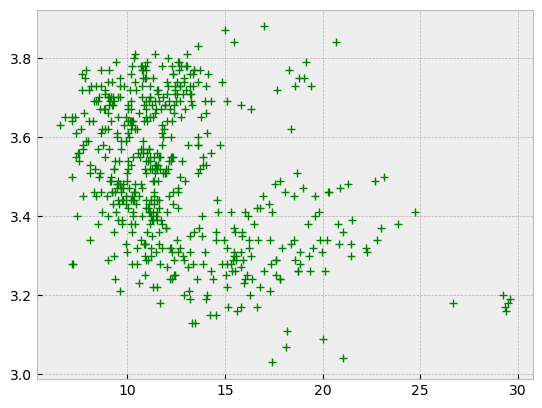

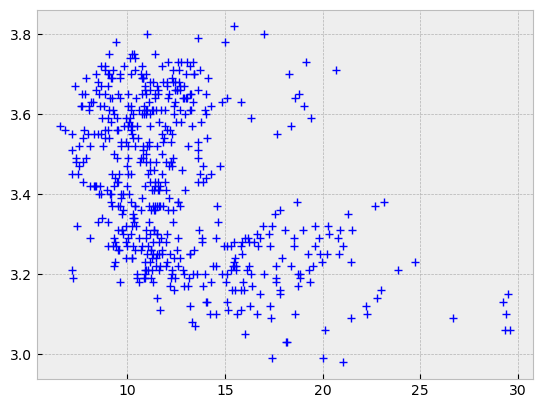

In [15]:
plt.plot(payPerStu,english, "g+")
plt.show()
plt.plot(payPerStu, science, "b+")
plt.show()

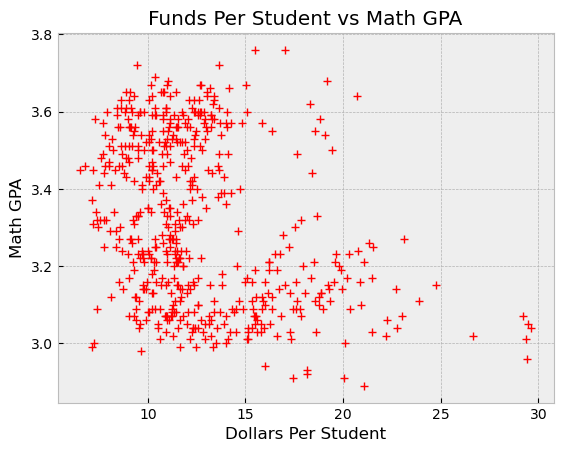

In [16]:
plt.plot(payPerStu, math, 'r+')
plt.title("Funds Per Student vs Math GPA")
plt.xlabel("Dollars Per Student")
plt.ylabel("Math GPA")
plt.show()

In [17]:
expend = stateScoresInfo['TOTAL_EXPENDITURE'] / stateScoresInfo['ENROLL']
stateScoresInfo['TOTAL_EXPENDITURE'] = expend

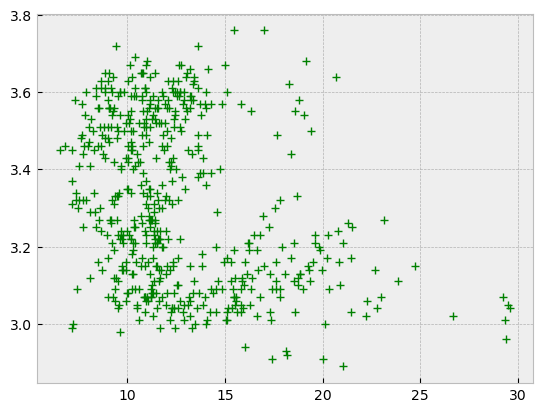

In [19]:
plt.plot(stateScoresInfo['TOTAL_EXPENDITURE'], stateScoresInfo['Academic Subjects.Mathematics.Average GPA'], 'g+')
plt.show()